In [106]:
import numpy as np
import polars as pl
import pandas as pd
import json
from datetime import datetime

In [34]:
data = pl.read_csv('Logs/log_1.csv', try_parse_dates=True)

In [94]:
from collections import UserList
class MsgReport(UserList):
    def __init__(self, report_desription=''):
        self.description = report_desription
        super().__init__()
    def show(self):
        self.show_header()
        for msg in self.data:
            self.show_msg(msg)
        self.show_footer()
    def show_msg(self, msg):
        print(msg)
    def show_header(self):
        print(self.description)
    def show_footer(self):
        pass

In [385]:

#set up the parser 
from ardupilot_log_reader import Ardupilot 
using_fields = [
    "AHR2", # Roll, Pitch, Yaw, Alt, Lat, Lng
    "ATT", # Simulation's roll/pitch/yaw
    "BARO", # Alt/SAML Alt Healt
    "BAT", # Gathered battery data
    "CMD", # command lat/lng/alt
    "CTUN", # desired-achieved-barometric-terrain alt
    "ERR", # errors messages
    "EV", # coded event messages
    "FNCE", # lat, lng
    "GPS", # gps status, NSats, Lat, Lng, Alt, Spd, VericalSpd
    "MCU", # MCU voltage and temperature
    "MODE", # vehical control mode
    "MOTB", # motor batVolt,
    "MSG", # message text
    "ORGN", # lat, lng, alt
    "PM", # autopilot system perfomance and gereral data 
    "POS", # lat, lng, alt, relhome alt, relorigin alt
    "POWR", # system power information
    "RATE", # desired and acvieved vehicle attitude rates
    "TERR", # terrain lat, lng, status
    "XKF1", # RPY
    "XKF4", # filtered error in roll/pitch estimate, filtered data GPS/fault,
    'PIDE', #Proportional/Integral/Derivative gain values for East/West velocity
]





In [386]:
class AnomalyDetector1D:
    def __init__(self, slow_n, quick_n, rel_threshold, abs_threshold):
        self.slow_n = slow_n
        self.quick_n = quick_n
        self.rel_threshold = rel_threshold
        self.abs_threshold = abs_threshold
    def detect(self, series: pd.Series):
        slow_part = self.slow_filter(series)
        quick_part = self.quick_filter(series)

        slow_quick_diff = (slow_part - quick_part).abs()
        rel_diff = slow_quick_diff / (quick_part + 1e-6)

        decision = (rel_diff > self.rel_threshold) & (slow_quick_diff > self.abs_threshold)
        decision_change = decision.astype(int).diff().fillna(0)
        df = pd.DataFrame({'value': series, 'slow_part': slow_part, 'quick_part': quick_part, 'abs_diff': slow_quick_diff, 'rel_diff': rel_diff, 'decision':decision,
                             'decision_change':decision_change})
        return df
    def slow_filter(self, series: pd.Series):
        return self.rolling_mean(series, self.slow_n) 
    def quick_filter(self, series: pd.Series):
        return self.rolling_mean(series, self.quick_n)
    def rolling_mean(self, series:pd.Series, n):
        return series.rolling(n, min_periods=1).mean()
class AnomalyDiffDetector1D(AnomalyDetector1D):
    def detect(self, series: pd.Series):
        diff = series.diff()
        return super().detect(diff)

class AnomalyGrouper:
    def transform(self, anomalies_df):
        
        df = anomalies_df.reset_index()
        df = df.where(df.RemPctChange != 0).dropna()
        #print(df)
        #df['prev_change_id'] = df['index'].shift(-1)
        #df['change_id'] = df.apply(lambda x: x.index if x.RemPctChange == 1 else x.prev_change_id, axis=1)
        df['change_id'] = (df['RemPctChange'] == 1).cumsum()

        #print(df)
        anomaly_intervals = df.groupby('change_id').agg(
            RemPctFrom=('timestamp',min),RemPctTo=('timestamp',max),
            RemPctFirst=('RemPct','first'),RemPctLast=('RemPct','last'))
        anomaly_intervals['RemPctChange'] = anomaly_intervals['RemPctLast'] - anomaly_intervals['RemPctFirst']
        return anomaly_intervals

In [387]:
import matplotlib.pyplot as plt
import pandas as pd


class BattPlot:
    def __init__(self, time_col, value_col, title, label_fmt, anomaly_detector=None):
        self.time_col = time_col
        self.value_col = value_col
        self.label_fmt = label_fmt
        self.title = title
        self.anomaly_detector = anomaly_detector
            
    def plot_instance(self, data, label):
        x = data[self.time_col]
        y = data[self.value_col]
        plt.plot(x, y, label=label)
    def plot(self, data):
        fig = plt.figure()
        plt.suptitle(self.title)
        for instance in data['Instance'].unique():
            instance_data = data[data.Instance == instance]
            if self.anomaly_detector is not None:
                detection = self.anomaly_detector.detect(instance_data['RemPct'])

                anomalies = AnomalyGrouper().transform(instance_data.join(detection['decision_change'].rename('RemPctChange'))).sort_values('RemPctFrom')    
                for i, anom in anomalies.iterrows():
                    plt.plot([anom['RemPctFrom'], anom['RemPctFrom']], [0,100])
            legend = self.label_fmt.format(instance)
            fig = self.plot_instance(instance_data, legend)
        plt.legend()


class BatteryStats(pd.DataFrame):
    def __init__(self, data):
        
        data = self.preproc(data)

        super().__init__(data)
    
    def preproc(self, data):
        # что-то сделать с временем, пересчитать в читаемые даты, пока не понял как
        data['timestamp'] = data['timestamp'].apply(datetime.fromtimestamp)
        return data
    def get_stats(self):
        stats = self \
                .sort_values('timestamp') \
                .groupby('Instance', sort=True) \
            .agg(start_bat=('RemPct', 'first'), end_bat=('RemPct', 'last'), 
                 mean_kw=('EnrgTot', 'mean'), max_kw=('EnrgTot', 'max'), min_kw=('EnrgTot', 'min')) \
            .reset_index()
        return stats
    def get_battery_log(self, instance):
        return self.where(self.Instance == instance).dropna()
    def plot_vs_time(self, value_col, title, label_fmt, anomaly_detector=None):

        return BattPlot('timestamp', value_col, title, label_fmt, anomaly_detector).plot(self)




In [435]:
from datetime import datetime

parser = Ardupilot.parse( 'Logs/log_8_2024-4-24-15-50-58.bin',types =using_fields) # fields to read from the log )

bat_ds = BatteryStats(parser.dfs['BAT'])


/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1412987708.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep curr

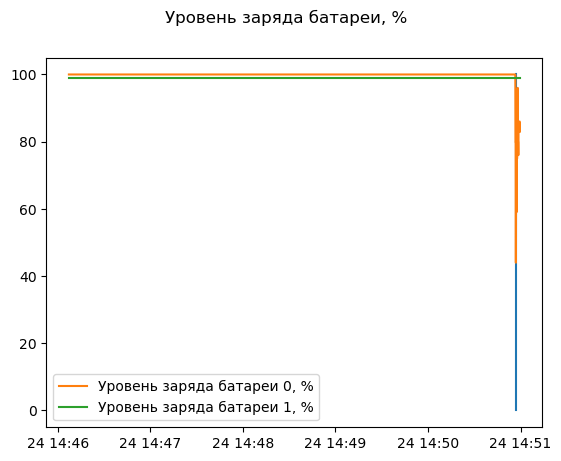

In [436]:
time_gap_detector = AnomalyDetector1D(1000,20, 0.1, 7)
bat_ds.plot_vs_time('RemPct', 'Уровень заряда батареи, %', 'Уровень заряда батареи {}, %', time_gap_detector)

In [374]:


time_gap_detector = AnomalyDiffDetector1D(100,10, 0.05, 1)
bat0_log = bat_ds.get_battery_log(0)

detection = time_gap_detector.detect(bat0_log['RemPct'])

anomalies = AnomalyGrouper().transform(bat0_log.join(detection['decision_change'].rename('RemPctChange'))).sort_values('RemPctFrom')

/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1018461661.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1018461661.py:41: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  anomaly_intervals = df.groupby('change_id').agg(


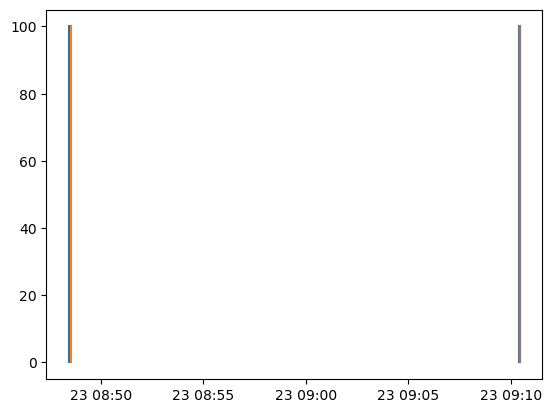

In [375]:
for i, anom in anomalies.iterrows():
    plt.plot([anom['RemPctFrom'], anom['RemPctFrom']], [0,100])

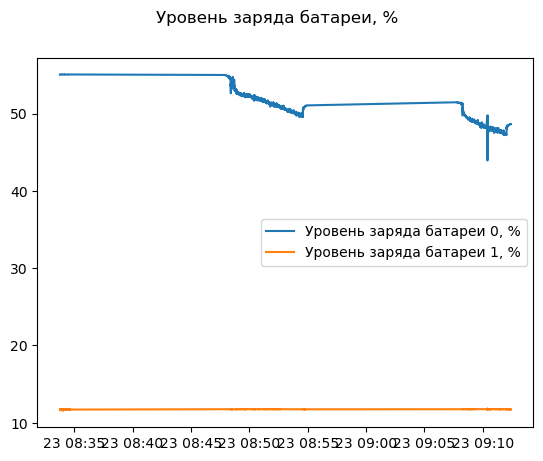

In [111]:
bat_ds.shift(-1)

,timestamp,TimeUS,Instance,Volt,VoltR,Curr,CurrTot,EnrgTot,Temp,Res,RemPct
0,2024-04-23 08:33:47.580433,5.147388e+08,1.0,11.720337,11.758342,0.353417,1.761724,0.020627,0.00,0.107535,99.0
1,2024-04-23 08:33:47.679881,5.148383e+08,0.0,55.031250,55.103577,0.470947,65.843651,3.626340,45.60,0.153581,100.0
2,2024-04-23 08:33:47.679904,5.148383e+08,1.0,11.705158,11.713626,0.078740,1.763900,0.020653,0.00,0.107535,99.0
3,2024-04-23 08:33:47.780377,5.149388e+08,0.0,55.031250,55.103767,0.470947,65.843651,3.626340,45.60,0.153978,100.0
4,2024-04-23 08:33:47.780387,5.149388e+08,1.0,11.729902,11.732189,0.021669,1.764505,0.020660,0.00,0.105532,99.0
...,...,...,...,...,...,...,...,...,...,...,...
15019,2024-04-23 09:12:24.179937,2.831338e+09,0.0,48.656250,60.796307,0.509766,374.182220,19.787691,46.10,23.814976,34.0
15020,2024-04-23 09:12:24.179947,2.831338e+09,1.0,11.746662,11.746672,0.024721,16740.513672,196.857117,0.00,0.000391,58.0
15021,2024-04-23 09:12:24.279948,2.831438e+09,0.0,48.656250,60.738163,0.507324,374.210327,19.789059,45.85,23.814976,34.0
15022,2024-04-23 09:12:24.279958,2.831438e+09,1.0,11.741286,11.741296,0.024721,16740.513672,196.857132,0.00,0.000393,58.0


/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1399116769.py:41: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  anomaly_intervals = df.groupby('change_id').agg(
/var/folders/9m/s1c10r5937z5zfl9b813zcz40000gp/T/ipykernel_91973/1399116769.py:41: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  anomaly_intervals = df.groupby('change_id').agg(


,RemPctFrom,RemPctTo,RemPctFirst,RemPctLast,RemPctChange
change_id,,,,,
1,2024-04-23 08:48:26.079974,2024-04-23 08:48:26.279958,88.0,88.0,0.0
2,2024-04-23 08:48:33.180213,2024-04-23 08:48:33.580337,100.0,96.0,-4.0
3,2024-04-23 09:10:24.079955,2024-04-23 09:10:24.779978,47.0,0.0,-47.0
4,2024-04-23 09:10:25.780022,2024-04-23 09:10:26.179972,22.0,28.0,6.0
5,2024-04-23 09:10:26.580028,2024-04-23 09:10:26.780165,29.0,28.0,-1.0


In [368]:
detection.where(detection.decision_change!=0).dropna()

,value,slow_part,quick_part,abs_diff,rel_diff,decision,decision_change
1526,-1.0,-0.11,1.0,1.11,1.109999,True,1.0
1530,0.0,-0.12,0.0,0.12,120000.000000,False,-1.0
1668,8.0,0.00,1.4,1.40,0.999999,True,1.0
1676,-4.0,0.02,1.0,0.98,0.979999,False,-1.0
12618,38.0,0.16,2.0,1.84,0.920000,True,1.0
12632,-31.0,-0.29,0.0,0.29,290000.000000,False,-1.0
12652,6.0,-0.09,2.2,2.29,1.040909,True,1.0
12660,1.0,-0.02,-0.8,0.78,-0.975001,False,-1.0
12668,-3.0,0.00,1.3,1.30,0.999999,True,1.0
12672,-1.0,-0.01,0.6,0.61,1.016665,False,-1.0


In [358]:
bat0_log.iloc[670:]

,timestamp,TimeUS,Instance,Volt,VoltR,Curr,CurrTot,EnrgTot,Temp,Res,RemPct
1340,2024-04-23 08:48:16.780358,1.383939e+09,0.0,54.78125,55.051674,0.464844,178.345337,9.816083,47.85,0.581749,100.0
1342,2024-04-23 08:48:16.879931,1.384038e+09,0.0,54.59375,54.863747,0.464111,178.371109,9.817491,47.85,0.581749,99.0
1344,2024-04-23 08:48:16.980225,1.384139e+09,0.0,54.59375,54.863747,0.464111,178.371109,9.817491,47.85,0.581749,99.0
1346,2024-04-23 08:48:17.079951,1.384238e+09,0.0,54.75000,55.024364,0.464600,178.396744,9.818894,47.85,0.590538,100.0
1348,2024-04-23 08:48:17.180181,1.384339e+09,0.0,54.75000,55.027767,0.464600,178.396744,9.818894,47.85,0.597860,100.0
...,...,...,...,...,...,...,...,...,...,...,...
15014,2024-04-23 09:12:23.879950,2.831038e+09,0.0,48.65625,60.488102,0.496826,374.153992,19.786318,45.85,23.814873,34.0
15016,2024-04-23 09:12:23.979956,2.831138e+09,0.0,48.65625,60.488152,0.496826,374.153992,19.786318,45.85,23.814976,34.0
15018,2024-04-23 09:12:24.079938,2.831238e+09,0.0,48.65625,60.796307,0.509766,374.182220,19.787691,46.10,23.814976,34.0
15020,2024-04-23 09:12:24.179937,2.831338e+09,0.0,48.65625,60.796307,0.509766,374.182220,19.787691,46.10,23.814976,34.0


In [325]:
x = bat0_log.join(detection['decision_change'].rename('RemPctChange'))
x.where(x.RemPctChange != 0).dropna()

,timestamp,TimeUS,Instance,Volt,VoltR,Curr,CurrTot,EnrgTot,Temp,Res,RemPct,RemPctChange
1326,2024-04-23 08:48:16.079947,1.383238e+09,0.0,54.56250,54.809540,0.467285,178.268005,9.811847,47.85,0.528668,99.0,1.0
1330,2024-04-23 08:48:16.279931,1.383438e+09,0.0,54.81250,55.068687,0.466553,178.293930,9.813268,47.85,0.549110,100.0,-1.0
1342,2024-04-23 08:48:16.879931,1.384038e+09,0.0,54.59375,54.863747,0.464111,178.371109,9.817491,47.85,0.581749,99.0,1.0
1350,2024-04-23 08:48:17.279940,1.384438e+09,0.0,54.84375,55.132923,0.464111,178.422455,9.820305,47.85,0.623072,100.0,-1.0
1354,2024-04-23 08:48:17.479932,1.384638e+09,0.0,54.59375,54.892673,0.464111,178.448486,9.821726,47.85,0.644077,99.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14784,2024-04-23 09:12:12.379948,2.819538e+09,0.0,48.53125,60.385166,0.496582,372.558319,19.708776,45.85,23.871010,33.0,-1.0
14788,2024-04-23 09:12:12.579950,2.819738e+09,0.0,48.53125,60.381523,0.496338,372.585754,19.710108,45.85,23.875416,33.0,1.0
14790,2024-04-23 09:12:12.679948,2.819838e+09,0.0,48.53125,60.393181,0.496826,372.613281,19.711443,45.85,23.875416,33.0,-1.0
14886,2024-04-23 09:12:17.479884,2.824638e+09,0.0,48.59375,60.431473,0.496338,373.274200,19.743536,45.85,23.850126,34.0,1.0


In [338]:
bat0_log.iloc[(12590+50)//2-10:].head(20)

,timestamp,TimeUS,Instance,Volt,VoltR,Curr,CurrTot,EnrgTot,Temp,Res,RemPct
12620,2024-04-23 09:10:24.179991,2.711338e+09,0.0,49.78125,58.548756,0.503906,357.436096,18.985907,46.1,17.399080,47.0
12622,2024-04-23 09:10:24.279886,2.711438e+09,0.0,48.75000,57.592026,0.501953,357.463715,18.987253,46.1,17.615238,35.0
12624,2024-04-23 09:10:24.379972,2.711538e+09,0.0,48.75000,57.682201,0.501953,357.463715,18.987253,46.1,17.794895,35.0
12626,2024-04-23 09:10:24.479969,2.711638e+09,0.0,48.81250,57.815903,0.501465,357.491577,18.988613,46.1,17.954208,36.0
12628,2024-04-23 09:10:24.579889,2.711738e+09,0.0,48.81250,57.882351,0.501465,357.491577,18.988613,46.1,18.086716,36.0
12630,2024-04-23 09:10:24.679940,2.711838e+09,0.0,48.37500,57.430676,0.500000,357.519348,18.989956,46.1,18.111351,31.0
12632,2024-04-23 09:10:24.779978,2.711938e+09,0.0,45.09375,55.036301,0.535156,357.548798,18.991283,46.1,18.578781,0.0
12634,2024-04-23 09:10:24.879878,2.712038e+09,0.0,45.09375,55.243683,0.535156,357.548798,18.991283,46.1,18.966299,0.0
12636,2024-04-23 09:10:24.979939,2.712138e+09,0.0,44.59375,54.768074,0.523926,357.577820,18.992579,46.1,19.419397,0.0
12638,2024-04-23 09:10:25.079946,2.712238e+09,0.0,44.59375,54.965599,0.523926,357.577820,18.992579,46.1,19.796412,0.0


In [268]:
detection = time_gap_detector.detect(bat0_log['RemPct'])
bat0_log['RemPctGap'] = detection.decision_change#.describe()

count    7512.000000
mean       80.194755
std        13.017108
min        58.000000
25%        70.000000
50%        80.000000
75%        92.000000
max        99.000000
Name: RemPct, dtype: float64


In [269]:
bat0_log


,timestamp,TimeUS,Instance,Volt,VoltR,Curr,CurrTot,EnrgTot,Temp,Res,RemPct,RemPctGap
1,2024-04-23 08:33:47.580433,5.147388e+08,1.0,11.720337,11.758342,0.353417,1.761724,0.020627,0.0,0.107535,99.0,0.0
3,2024-04-23 08:33:47.679904,5.148383e+08,1.0,11.705158,11.713626,0.078740,1.763900,0.020653,0.0,0.107535,99.0,0.0
5,2024-04-23 08:33:47.780387,5.149388e+08,1.0,11.729902,11.732189,0.021669,1.764505,0.020660,0.0,0.105532,99.0,0.0
7,2024-04-23 08:33:47.879919,5.150383e+08,1.0,11.724842,11.726287,0.014039,1.764893,0.020664,0.0,0.102888,99.0,0.0
9,2024-04-23 08:33:47.980390,5.151388e+08,1.0,11.713696,11.714777,0.010512,1.765186,0.020668,0.0,0.102888,99.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15015,2024-04-23 09:12:23.879960,2.831038e+09,1.0,11.747453,11.747462,0.023805,16740.513672,196.857086,0.0,0.000391,58.0,0.0
15017,2024-04-23 09:12:23.979967,2.831138e+09,1.0,11.741716,11.741726,0.024077,16740.513672,196.857101,0.0,0.000391,58.0,0.0
15019,2024-04-23 09:12:24.079948,2.831238e+09,1.0,11.742234,11.742244,0.023195,16740.513672,196.857101,0.0,0.000391,58.0,0.0
15021,2024-04-23 09:12:24.179947,2.831338e+09,1.0,11.746662,11.746672,0.024721,16740.513672,196.857117,0.0,0.000391,58.0,0.0


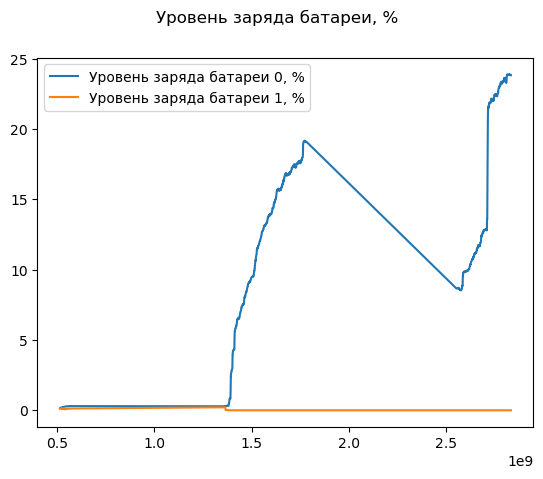

In [89]:
from datetime import datetime
bat_ds = BatteryStats(parser.dfs['BAT'])#['TimeUS'].apply(lambda x: datetime.fromtimestamp(x*10))
bat_ds.plot_vs_time('Res', 'Уровень заряда батареи, %', 'Уровень заряда батареи {}, %')

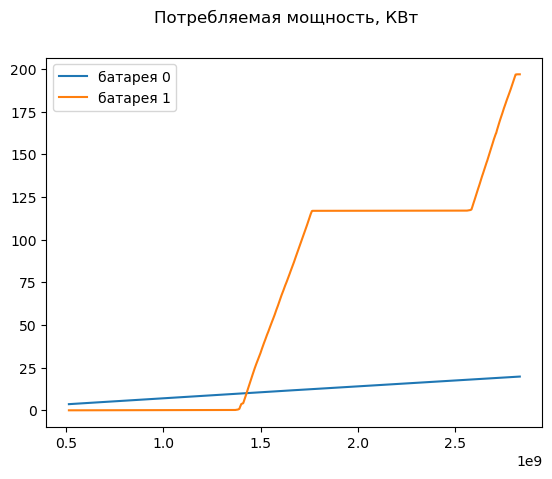

In [90]:
bat_ds.plot_vs_time('EnrgTot', 'Потребляемая мощность, КВт', 'батарея {}')

In [99]:
class BatteryStatMessage:
    _format = "Батарея №: {instance:.0f}, Заряд на старте,%: {start_bat}, Заряд в конце,%: {end_bat}, Средняя потребл. мощность, КВт: {mean_kw}"
    def __init__(self, data_tuple):
        self.instance, self.start_bat, self.end_bat, self.mean_kw, self.max_kw, self.min_kw = data_tuple
    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        
        return self._format.format(
            instance=self.instance,
            start_bat=self.start_bat,
            end_bat=self.end_bat,
            mean_kw=self.mean_kw
        )

battery_report = MsgReport()
battery_info = bat_ds.get_stats().sort_values('Instance')    
for i, bat_stat in battery_info.iterrows():
    battery_report.append(BatteryStatMessage(bat_stat))
battery_report.show()



Батарея №: 0, Заряд на старте,%: 100.0, Заряд в конце,%: 34.0, Средняя потребл. мощность, КВт: 13.616861151461912
Батарея №: 1, Заряд на старте,%: 99.0, Заряд в конце,%: 58.0, Средняя потребл. мощность, КВт: 90.77404712128336


In [92]:
from datetime import datetime
from collections import UserList

with open('err_codes.json')as f:
    ERRROR_DESCRIPTIONS = pd.DataFrame(json.load(f))
ERRROR_DESCRIPTIONS


class ErrorMessage:
    _format = "Time: {time}, Subsystem Code: {subsys_code}, Subsystem Name: {subsys_name}, Description: {description}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Subsys, self.ECode, self.subsys_name, self.description = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            subsys_code=self.Subsys,
            subsys_name=self.subsys_name,
            description=self.description
        )

msg_log = parser.dfs['ERR'].merge(ERRROR_DESCRIPTIONS, on='Subsys ECode'.split())

msg_log = msg_log.sort_values('timestamp')
err_report = MsgReport()

for i, msg in msg_log.iterrows():
    err_report.append(ErrorMessage(msg))
err_report.show()


Time: 2024-04-23 08:56:18, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 08:56:18, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered
Time: 2024-04-23 08:56:26, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Resolved
Time: 2024-04-23 08:57:05, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 08:57:05, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered
Time: 2024-04-23 09:06:15, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Resolved
Time: 2024-04-23 09:13:17, Subsystem Code: 2, Subsystem Name: Radio, Description: Late Frame : no updates received from receiver for two seconds
Time: 2024-04-23 09:13:17, Subsystem Code: 5, Subsystem Name: Radio Failsafe, Description: Failsafe Triggered


In [66]:
with open('mode_codes.json') as f: 
  MESSAGE_DESCRIPTIONS = pd.DataFrame(json.load(f))


class ModeMessage:
    _format = "Time: {time}, Mode: {Mode}, Reason: {Reason}, Description: {description}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Mode, self.ModeNum, self.Rsn, self.message = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            Mode=self.Mode,
            Reason=self.Rsn,
            description=self.message
        )



msg_log = parser.dfs['MODE'].merge(MESSAGE_DESCRIPTIONS, on='Rsn')
msg_log = msg_log.sort_values('timestamp')

mode_report = MsgReport()
for i, msg in msg_log.iterrows():
  mode_report.append(ModeMessage(msg))
mode_report.show()

Time: 2024-04-23 08:33:47, Mode: 0, Reason: 26, Description: INITIALISED
Time: 2024-04-23 08:47:54, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:51:44, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:53:01, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:00, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:04, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:46, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:49, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:52, Mode: 0, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:56, Mode: 2, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:56, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:55:58, Mode: 3, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:56:00, Mode: 5, Reason: 1, Description: RC_COMMAND
Time: 2024-04-23 08:56:10, Mode: 0, Reason: 1, Description: RC_COMMAND
Time

In [79]:
with open('ev_codes.json') as f: 
  EV_CODES = pd.DataFrame(json.load(f)) \
    .rename({'value':'Id'}, axis=1)


class EvMessage:
    _format = "Time: {time}, Id: {Id}, Message: {Message}"

    def __init__(self, data_tuple):
        self.timestamp, self.TimeUS, self.Id, self.Message = data_tuple

    def __str__(self):
        # Преобразование timestamp в читаемый формат даты и времени
        time_str = datetime.fromtimestamp(self.timestamp).strftime('%Y-%m-%d %H:%M:%S')
        
        return self._format.format(
            time=time_str,
            Id=self.Id,
            Message=self.Message
        )



msg_log = parser.dfs['EV'].merge(EV_CODES, on='Id')
msg_log = msg_log.sort_values('timestamp')

ev_report = MsgReport()
for i, msg in msg_log.iterrows():
  ev_report.append(EvMessage(msg))
ev_report.show()


Time: 2024-04-23 08:33:47, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:33:58, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:34:11, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:34:25, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:47:56, Id: 57, Message: MOTORS_INTERLOCK_ENABLED
Time: 2024-04-23 08:48:00, Id: 15, Message: AUTO_ARMED
Time: 2024-04-23 08:48:23, Id: 28, Message: NOT_LANDED
Time: 2024-04-23 08:48:33, Id: 17, Message: LAND_COMPLETE_MAYBE
Time: 2024-04-23 08:48:34, Id: 18, Message: LAND_COMPLETE
Time: 2024-04-23 08:48:43, Id: 28, Message: NOT_LANDED
Time: 2024-04-23 08:54:36, Id: 17, Message: LAND_COMPLETE_MAYBE
Time: 2024-04-23 08:54:36, Id: 18, Message: LAND_COMPLETE
Time: 2024-04-23 08:54:39, Id: 11, Message: DISARMED
Time: 2024-04-23 08:54:39, Id: 56, Message: MOTORS_INTERLOCK_DISABLED
Time: 2024-04-23 08:55:58, Id: 15, Message: AUTO_ARMED
Time: 2024-04-23 08:55:58, Id: 15, Message: AUTO_ARMED
Time: 20

In [72]:
parser.dfs['EV']

,timestamp,TimeUS,Id
0,1.713850e+09,514685651,56
1,1.713850e+09,525735455,56
2,1.713850e+09,538257953,56
3,1.713850e+09,552472952,56
4,1.713851e+09,1363640452,57
...,...,...,...
201,1.713853e+09,2842940669,15
202,1.713853e+09,2842960637,15
203,1.713853e+09,2842980941,15
204,1.713853e+09,2843000654,15


In [50]:
for k,v in parser.dfs.items():
    print(k, v.columns)

PARM Index(['timestamp', 'TimeUS', 'Name', 'Value', 'Default'], dtype='object')
EV Index(['timestamp', 'TimeUS', 'Id'], dtype='object')
GPS Index(['timestamp', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop',
       'Lat', 'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U'],
      dtype='object')
POWR Index(['timestamp', 'TimeUS', 'Vcc', 'VServo', 'Flags', 'AccFlags', 'Safety'], dtype='object')
MCU Index(['timestamp', 'TimeUS', 'MTemp', 'MVolt', 'MVmin', 'MVmax'], dtype='object')
BAT Index(['timestamp', 'TimeUS', 'Instance', 'Volt', 'VoltR', 'Curr', 'CurrTot',
       'EnrgTot', 'Temp', 'Res', 'RemPct'],
      dtype='object')
BARO Index(['timestamp', 'TimeUS', 'I', 'Alt', 'Press', 'Temp', 'CRt', 'SMS',
       'Offset', 'GndTemp', 'Health'],
      dtype='object')
CTUN Index(['timestamp', 'TimeUS', 'ThI', 'ABst', 'ThO', 'ThH', 'DAlt', 'Alt',
       'BAlt', 'DSAlt', 'SAlt', 'TAlt', 'DCRt', 'CRt'],
      dtype='object')
ATT Index(['timestamp', 'TimeUS', 'DesRoll', 'Roll', 'DesPitch', 'Pit